In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from os import listdir
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score
from joblib import dump, load

In [27]:
stock = "nvda.csv"

In [28]:
folder = "prepared_stock_data"
data = pd.read_csv(folder + "//" + stock, index_col = "Unnamed: 0").drop(['Label'],axis=1)

In [29]:
folder = "stock_data"
prices = pd.read_csv(folder + "//" + stock, index_col = "Date")["Close"]
prices = prices.loc["2019-01-01":"2020-01-01"]

In [30]:
data = data.loc["2019-01-01":"2020-01-01"]
dates = data.index
X = np.asanyarray(data.drop("Name", axis = 1))
X = torch.tensor(X).float()

In [7]:
class DNN_Model1(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out=2, p=0.5):
        super(DNN_Model1, self).__init__()
        self.drop = nn.Dropout(p = p)
        self.channel1_l1 = nn.Linear(D_in, H1)
        self.channel1_l2 = nn.Linear(H1, H2)
        self.channel1_l3 = nn.Linear(H2, H3)
        
        self.channel2_l1 = nn.Linear(D_in, H1)
        self.channel2_l2 = nn.Linear(H1, H2)
        self.channel2_l3 = nn.Linear(H2, H3)
        
        self.out = nn.Linear(H3, D_out)

    def forward(self, x):
        x = torch.max(self.drop(self.channel1_l1(x)), self.drop(self.channel2_l1(x)))
        x = torch.max(self.drop(self.channel1_l2(x)), self.drop(self.channel2_l2(x)))
        x = torch.max(self.drop(self.channel1_l3(x)), self.drop(self.channel2_l3(x)))
        x = F.softmax(self.out(x))
        return x

In [8]:
class DNN_Carlos(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out=2):
        super(DNN_Carlos, self).__init__()
        self.drop1 = nn.Dropout(p = 0.5)
        self.drop2 = nn.Dropout(p = 0.25)
        
        self.linear1_1 = nn.Linear(D_in, H1)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear1_1.weight)
        self.linear2_1 = nn.Linear(H1, H2)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear2_1.weight)
        self.linear3_1 = nn.Linear(H2, H3)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear3_1.weight)
        self.linear1_2 = nn.Linear(D_in, H1)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear1_2.weight)
        self.linear2_2 = nn.Linear(H1, H2)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear2_2.weight)
        self.linear3_2 = nn.Linear(H2, H3)
        torch.nn.init.torch.nn.init.xavier_uniform_(self.linear3_2.weight)
        
        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)
        self.bn3 = nn.BatchNorm1d(H3)
        
        self.out = nn.Linear(H3, D_out)

    def forward(self, x):
        x = torch.max(self.bn1(self.drop1(self.linear1_1(x))), self.bn1(self.drop1(self.linear1_2(x))))
        x = torch.max(self.bn2(self.drop2(self.linear2_1(x))), self.bn2(self.drop2(self.linear2_2(x))))
        x = torch.max(self.bn3(self.linear3_1(x)), self.bn3(self.linear3_2(x)))
        x = F.softmax(self.out(x))
        return x

In [9]:
input_dim = 31
hidden1 = 31
hidden2 = 10
hidden3 = 5
out_dim = 2
dropout_rate = 0.5

In [10]:
PATH = "models//model1_2019.pth"
DNN_model = DNN_Model1(input_dim, hidden1, hidden2, hidden3, out_dim, dropout_rate)
DNN_model.load_state_dict(torch.load(PATH))
DNN_model.eval()

DNN_Model1(
  (drop): Dropout(p=0.5, inplace=False)
  (channel1_l1): Linear(in_features=31, out_features=31, bias=True)
  (channel1_l2): Linear(in_features=31, out_features=10, bias=True)
  (channel1_l3): Linear(in_features=10, out_features=5, bias=True)
  (channel2_l1): Linear(in_features=31, out_features=31, bias=True)
  (channel2_l2): Linear(in_features=31, out_features=10, bias=True)
  (channel2_l3): Linear(in_features=10, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

In [11]:
input_dim = 31
hidden1 = 31
hidden2 = 10
hidden3 = 5
out_dim = 2
DNNCarlos_Model = DNN_Carlos(input_dim, hidden1, hidden2, hidden3, out_dim)

In [12]:
PATH = "models//modelCarlos_2019.pth"
DNNCarlos_Model.load_state_dict(torch.load(PATH))
DNNCarlos_Model.eval()

DNN_Carlos(
  (drop1): Dropout(p=0.5, inplace=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (linear1_1): Linear(in_features=31, out_features=31, bias=True)
  (linear2_1): Linear(in_features=31, out_features=10, bias=True)
  (linear3_1): Linear(in_features=10, out_features=5, bias=True)
  (linear1_2): Linear(in_features=31, out_features=31, bias=True)
  (linear2_2): Linear(in_features=31, out_features=10, bias=True)
  (linear3_2): Linear(in_features=10, out_features=5, bias=True)
  (bn1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

## Deep Neural Network Model Returns

In [31]:
z = DNN_model(X)
_, y_hat = torch.max(z,1)
y_hat = y_hat.numpy()
signalsDNN = pd.DataFrame({"Signal":y_hat, "Price":prices}, index = dates)
dates = signalsDNN.index
signalsDNN.head(5)

/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,Signal,Price
2019-01-02,0,135.55
2019-01-03,0,127.36
2019-01-04,0,135.52
2019-01-07,1,142.69
2019-01-08,1,139.14


In [32]:
budget = 100000
investment = 0
prevSignal = -1
prevPrice = -1
for i, date in enumerate(dates):
    inf = signalsDNN.loc[date]
    curSignal = inf["Signal"]
    curPrice = inf["Price"]
    if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
        investment += budget
        budget = 0
        prevPrice = curPrice
        print(date, "BUY, INVESTMENT: $", np.round(investment,3), curPrice)
    elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
        budget = curPrice/prevPrice * investment
        investment = 0
        print(date, "SELL, BUDGET   : $",np.round(budget,3), curPrice)
    prevSignal = curSignal
    
print("final budget: $", budget)
print("Return: ", budget/100000 - 1)

2019-01-02 BUY, INVESTMENT: $ 100000 135.55
2019-01-07 SELL, BUDGET   : $ 105267.429 142.69
2019-01-10 BUY, INVESTMENT: $ 105267.429 144.51
2019-01-11 SELL, BUDGET   : $ 107875.258 148.09
2019-01-17 BUY, INVESTMENT: $ 107875.258 150.97
2019-01-18 SELL, BUDGET   : $ 111576.615 156.15
2019-01-23 BUY, INVESTMENT: $ 111576.615 148.55
2019-01-25 SELL, BUDGET   : $ 119696.058 159.36
2019-01-28 BUY, INVESTMENT: $ 119696.058 137.33
2019-01-31 SELL, BUDGET   : $ 124672.862 143.04
2019-02-08 BUY, INVESTMENT: $ 124672.862 147.44
2019-02-12 SELL, BUDGET   : $ 127192.701 150.42
2019-02-20 BUY, INVESTMENT: $ 127192.701 157.77
2019-02-21 SELL, BUDGET   : $ 124959.553 155.0
2019-02-22 BUY, INVESTMENT: $ 124959.553 158.4
2019-02-25 SELL, BUDGET   : $ 124572.999 157.91
2019-02-26 BUY, INVESTMENT: $ 124572.999 156.32
2019-03-04 SELL, BUDGET   : $ 124453.462 156.17
2019-03-05 BUY, INVESTMENT: $ 124453.462 155.91
2019-03-12 SELL, BUDGET   : $ 129218.95 161.88
2019-03-25 BUY, INVESTMENT: $ 129218.95 173.1
2

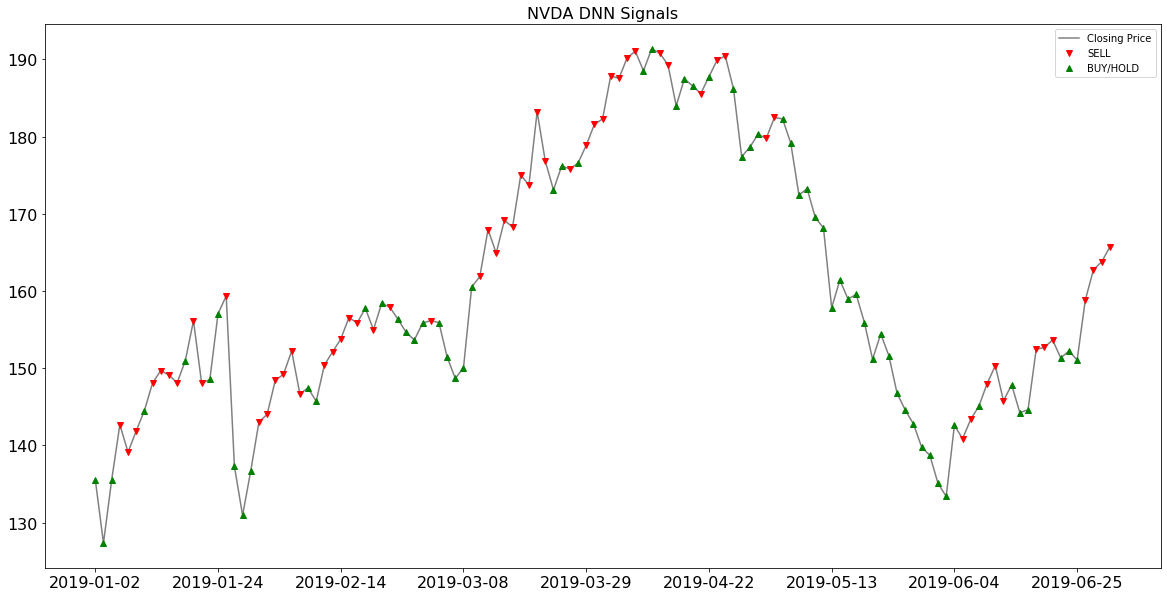

In [45]:
information = signalsDNN.loc["2019-01-01":"2019-07-01"]
plt.figure(figsize = (20,10))
plt.title(stock.split(".")[0].upper() + " DNN Signals", fontsize = 16)
plt.plot(information["Price"], color = "gray", label = "Closing Price")
plt.plot(information["Price"][information["Signal"] == 1], 'v', color = 'r', label = "SELL")
plt.plot(information["Price"][information["Signal"] == 0], '^', color = 'g', label = "BUY/HOLD")
plt.legend()

plt.xticks(information.index[::15], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

## Carlos' DNN Model Returns

In [34]:
z = DNNCarlos_Model(X)
_, y_hat = torch.max(z,1)
y_hat = y_hat.numpy()
signalsDNNCarlos = pd.DataFrame({"Signal":y_hat, "Price":prices}, index = dates)
dates = signalsDNNCarlos.index
signalsDNNCarlos.head(5)

/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,Signal,Price
2019-01-02,0,135.55
2019-01-03,0,127.36
2019-01-04,0,135.52
2019-01-07,1,142.69
2019-01-08,1,139.14


In [35]:
budget = 100000
investment = 0
prevSignal = -1
prevPrice = -1
for i, date in enumerate(dates):
    inf = signalsDNNCarlos.loc[date]
    curSignal = inf["Signal"]
    curPrice = inf["Price"]
    if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
        investment += budget
        budget = 0
        prevPrice = curPrice
        print(date, "BUY, INVESTMENT: $", np.round(investment,3), curPrice)
    elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
        budget = curPrice/prevPrice * investment
        investment = 0
        print(date, "SELL, BUDGET   : $",np.round(budget,3), curPrice)
    prevSignal = curSignal
    
print("final budget: $", budget)
print("Return: ", budget/100000 - 1)

2019-01-02 BUY, INVESTMENT: $ 100000 135.55
2019-01-07 SELL, BUDGET   : $ 105267.429 142.69
2019-01-09 BUY, INVESTMENT: $ 105267.429 141.88
2019-01-14 SELL, BUDGET   : $ 111069.454 149.7
2019-01-17 BUY, INVESTMENT: $ 111069.454 150.97
2019-01-22 SELL, BUDGET   : $ 108913.837 148.04
2019-01-23 BUY, INVESTMENT: $ 108913.837 148.55
2019-01-25 SELL, BUDGET   : $ 116839.509 159.36
2019-01-28 BUY, INVESTMENT: $ 116839.509 137.33
2019-02-01 SELL, BUDGET   : $ 122531.319 144.02
2019-02-07 BUY, INVESTMENT: $ 122531.319 146.69
2019-02-13 SELL, BUDGET   : $ 127067.041 152.12
2019-02-20 BUY, INVESTMENT: $ 127067.041 157.77
2019-03-12 SELL, BUDGET   : $ 130377.211 161.88
2019-03-15 BUY, INVESTMENT: $ 130377.211 169.15
2019-03-19 SELL, BUDGET   : $ 134901.682 175.02
2019-03-21 BUY, INVESTMENT: $ 134901.682 183.22
2019-03-22 SELL, BUDGET   : $ 130182.111 176.81
2019-03-25 BUY, INVESTMENT: $ 130182.111 173.1
2019-04-01 SELL, BUDGET   : $ 136552.085 181.57
2019-04-02 BUY, INVESTMENT: $ 136552.085 182.2

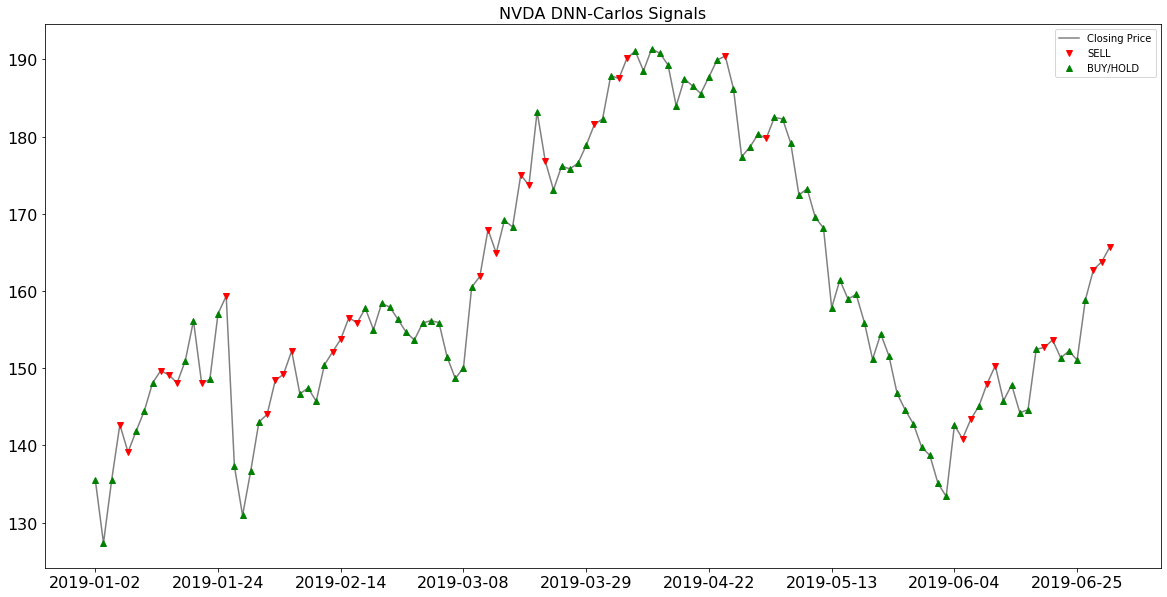

In [47]:
information = signalsDNNCarlos.loc["2019-01-01":"2019-07-01"]
plt.figure(figsize = (20,10))
plt.title(stock.split(".")[0].upper() + " DNN-Carlos Signals", fontsize = 16)
plt.plot(information["Price"], color = "gray", label = "Closing Price")
plt.plot(information["Price"][information["Signal"] == 1], 'v', color = 'r', label = "SELL")
plt.plot(information["Price"][information["Signal"] == 0], '^', color = 'g', label = "BUY/HOLD")
plt.legend()

plt.xticks(information.index[::15], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

## Random Forest Model Returns

In [19]:
modelRF = load('RandomForest2019.joblib')

In [37]:
y_hat = modelRF.predict(X.numpy())
signalsRF = pd.DataFrame({"Signal":y_hat, "Price":prices}, index = dates)
signalsRF.head(5)

,Signal,Price
2019-01-02,0,135.55
2019-01-03,0,127.36
2019-01-04,0,135.52
2019-01-07,1,142.69
2019-01-08,1,139.14


In [38]:
budget = 100000
investment = 0
prevSignal = -1
prevPrice = -1
for i, date in enumerate(dates):
    inf = signalsRF.loc[date]
    curSignal = inf["Signal"]
    curPrice = inf["Price"]
    if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
        investment += budget
        budget = 0
        prevPrice = curPrice
        print(date, "BUY, INVESTMENT: $", np.round(investment,3), curSignal, curPrice)
    elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
        budget = curPrice/prevPrice * investment
        investment = 0
        print(date, "SELL, BUDGET   : $",np.round(budget,3), curSignal, curPrice)
    prevSignal = curSignal
    
print("final budget: $", budget)
print("Return: ", budget/100000 - 1)

2019-01-02 BUY, INVESTMENT: $ 100000 0.0 135.55
2019-01-07 SELL, BUDGET   : $ 105267.429 1.0 142.69
2019-01-10 BUY, INVESTMENT: $ 105267.429 0.0 144.51
2019-01-11 SELL, BUDGET   : $ 107875.258 1.0 148.09
2019-01-17 BUY, INVESTMENT: $ 107875.258 0.0 150.97
2019-01-18 SELL, BUDGET   : $ 111576.615 1.0 156.15
2019-01-23 BUY, INVESTMENT: $ 111576.615 0.0 148.55
2019-01-25 SELL, BUDGET   : $ 119696.058 1.0 159.36
2019-01-28 BUY, INVESTMENT: $ 119696.058 0.0 137.33
2019-02-01 SELL, BUDGET   : $ 125527.024 1.0 144.02
2019-02-08 BUY, INVESTMENT: $ 125527.024 0.0 147.44
2019-02-12 SELL, BUDGET   : $ 128064.128 1.0 150.42
2019-02-20 BUY, INVESTMENT: $ 128064.128 0.0 157.77
2019-02-21 SELL, BUDGET   : $ 125815.68 1.0 155.0
2019-02-22 BUY, INVESTMENT: $ 125815.68 0.0 158.4
2019-02-25 SELL, BUDGET   : $ 125426.477 1.0 157.91
2019-02-27 BUY, INVESTMENT: $ 125426.477 0.0 154.64
2019-03-04 SELL, BUDGET   : $ 126667.44 1.0 156.17
2019-03-05 BUY, INVESTMENT: $ 126667.44 0.0 155.91
2019-03-11 SELL, BUDGE

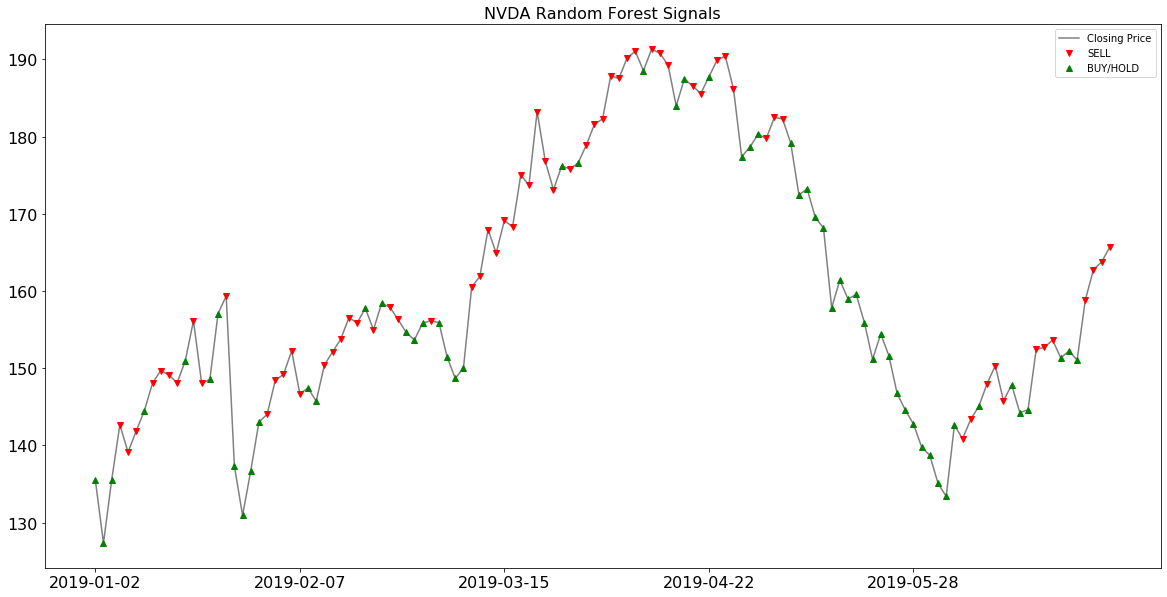

In [43]:
information = signalsRF.loc["2019-01-01":"2019-07-01"]
plt.figure(figsize = (20,10))
plt.title(stock.split(".")[0].upper() + " Random Forest Signals", fontsize = 16)
plt.plot(information["Price"], color = "gray", label = "Closing Price")
plt.plot(information["Price"][information["Signal"] == 1], 'v', color = 'r', label = "SELL")
plt.plot(information["Price"][information["Signal"] == 0], '^', color = 'g', label = "BUY/HOLD")
plt.legend()

plt.xticks(information.index[::25], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

## Gradient Boost Trees Model Returns

In [23]:
modelGB = load('GBT_2019.joblib')

In [40]:
y_hat = modelGB.predict(X.numpy())
signalsGB = pd.DataFrame({"Signal":y_hat, "Price":prices}, index = dates)
signalsGB.head(5)

,Signal,Price
2019-01-02,0,135.55
2019-01-03,0,127.36
2019-01-04,1,135.52
2019-01-07,1,142.69
2019-01-08,1,139.14


In [41]:
budget = 100000
investment = 0
prevSignal = -1
prevPrice = -1
for i, date in enumerate(dates):
    inf = signalsGB.loc[date]
    curSignal = inf["Signal"]
    curPrice = inf["Price"]
    if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
        investment += budget
        budget = 0
        prevPrice = curPrice
        print(date, "BUY, INVESTMENT: $", np.round(investment,3), curSignal, curPrice)
    elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
        budget = curPrice/prevPrice * investment
        investment = 0
        print(date, "SELL, BUDGET   : $",np.round(budget,3), curSignal, curPrice)
    prevSignal = curSignal
    
print("final budget: $", budget)
print("Return: ", budget/100000 - 1)

2019-01-02 BUY, INVESTMENT: $ 100000 0.0 135.55
2019-01-04 SELL, BUDGET   : $ 99977.868 1.0 135.52
2019-01-10 BUY, INVESTMENT: $ 99977.868 0.0 144.51
2019-01-11 SELL, BUDGET   : $ 102454.657 1.0 148.09
2019-01-17 BUY, INVESTMENT: $ 102454.657 0.0 150.97
2019-01-18 SELL, BUDGET   : $ 105970.025 1.0 156.15
2019-01-23 BUY, INVESTMENT: $ 105970.025 0.0 148.55
2019-01-25 SELL, BUDGET   : $ 113681.475 1.0 159.36
2019-01-28 BUY, INVESTMENT: $ 113681.475 0.0 137.33
2019-01-31 SELL, BUDGET   : $ 118408.201 1.0 143.04
2019-02-08 BUY, INVESTMENT: $ 118408.201 0.0 147.44
2019-02-12 SELL, BUDGET   : $ 120801.422 1.0 150.42
2019-02-20 BUY, INVESTMENT: $ 120801.422 0.0 157.77
2019-02-21 SELL, BUDGET   : $ 118680.486 1.0 155.0
2019-02-22 BUY, INVESTMENT: $ 118680.486 0.0 158.4
2019-02-25 SELL, BUDGET   : $ 118313.356 1.0 157.91
2019-02-27 BUY, INVESTMENT: $ 118313.356 0.0 154.64
2019-03-04 SELL, BUDGET   : $ 119483.942 1.0 156.17
2019-03-05 BUY, INVESTMENT: $ 119483.942 0.0 155.91
2019-03-11 SELL, BUD

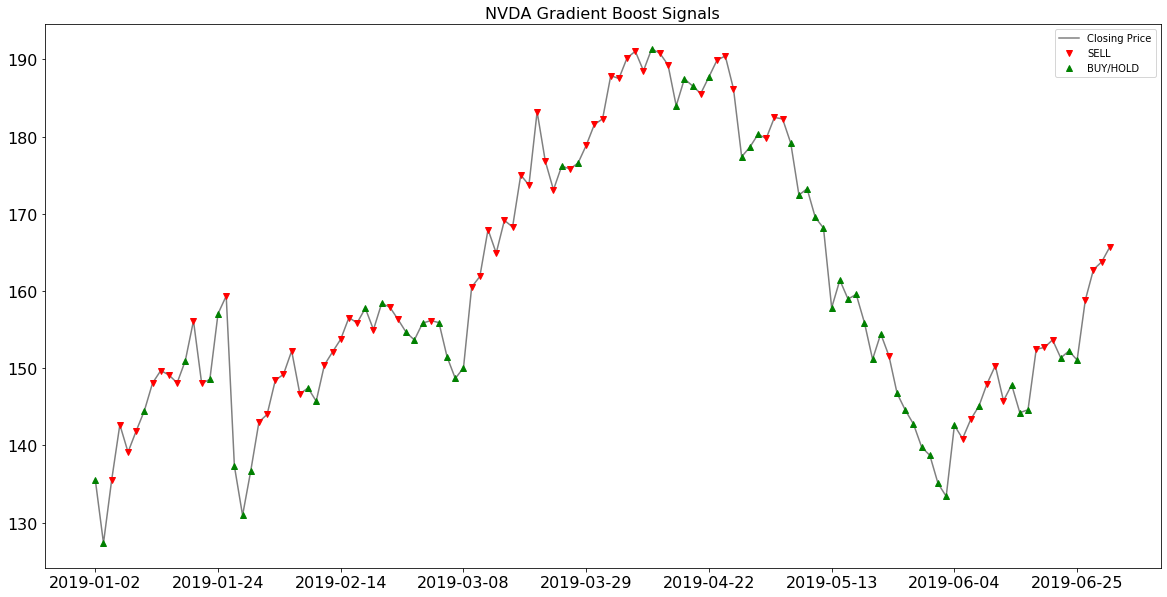

In [42]:
information = signalsGB.loc["2019-01-01":"2019-07-01"]
plt.figure(figsize = (20,10))
plt.title(stock.split(".")[0].upper() + " Gradient Boost Signals", fontsize = 16)
plt.plot(information["Price"], color = "gray", label = "Closing Price")
plt.plot(information["Price"][information["Signal"] == 1], 'v', color = 'r', label = "SELL")
plt.plot(information["Price"][information["Signal"] == 0], '^', color = 'g', label = "BUY/HOLD")
plt.legend()

plt.xticks(information.index[::15], fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()